In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline  
import pickle
from collections import defaultdict
import re
from build_movie_data import *
from build_franchise_ds import *
from datetime import datetime
import dateutil.parser
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%base16_mplrc light default
%matplotlib inline

ImportError: No module named 'build_movie_data'

In [4]:
with open("franchise_data.pkl", 'rb') as picklefile:
    complete_data_for_pandas = pickle.load(picklefile)
df_complete = pd.DataFrame(complete_data_for_pandas)

FileNotFoundError: [Errno 2] No such file or directory: 'franchise_data.pkl'

In [21]:
HTML(df_complete[['title','release_date','budget','runtime','domestic_total_gross','genre','metacritic']].to_html())

,title,release_date,budget,runtime,domestic_total_gross,genre,metacritic
0,Mission: Impossible II,2000-05-24,125000000,123,331707300,Action,60
1,Mission: Impossible - Ghost Protocol,2011-12-16,145000000,132,220678400,Action,73
2,Mission: Impossible,1996-05-22,80000000,110,339852800,Action,60
3,Mission: Impossible III,2006-05-05,150000000,126,169839300,Action,66
4,Mission Impossible 5,2015-07-31,NaN,NaN,0,Action,NaN
5,Scream,1996-12-20,14000000,110,187184000,Horror,65
6,Scream 2,1997-12-12,24000000,120,181776000,Horror,63
7,Scream 3,2000-02-04,40000000,117,137270600,Horror,56
8,Scream 4,2011-04-15,40000000,103,39317800,Horror,52
9,Return of the Living Dead,1985-08-16,NaN,114,33288600,Horror Comedy,NaN


In [3]:
df_complete[['budget','runtime']].sort(['runtime'], ascending=[1])

,budget,runtime
618,NaN,44
628,16000000,70
63,NaN,76
236,NaN,76
617,NaN,77
616,2000000,77
389,30000000,78
629,NaN,79
576,5000000,80
630,NaN,80


In [4]:
df_sorted_date = df_complete.sort(columns='release_date')
franchise_groups = df_sorted_date.dropna(subset=['franchise']).groupby('franchise')

In [10]:
franchises_dict_list = []
for franchise, movies_df in franchise_groups:
    movies_df.drop_duplicates('title', inplace=True)
    if franchise == 'lordoftherings':
        movies_df = movies_df[movies_df.rating != 'PG']
    franchise_dict = {}
    try:
        franchise_dict['first_title'] = movies_df['title'].iloc[0]
        franchise_dict['second_title'] = movies_df['title'].iloc[1]  
        franchise_dict['new_title'] = movies_df['title'].iloc[2] 
        franchise_dict['franchise'] = franchise
        franchise_dict['first_gross'] = movies_df['domestic_total_gross'].iloc[0] 
        franchise_dict['second_gross'] = movies_df['domestic_total_gross'].iloc[1] 
        franchise_dict['prev_gross'] = (movies_df['domestic_total_gross'].iloc[0] + movies_df['domestic_total_gross'].iloc[1])/float(2)
        franchise_dict['act_gross'] = movies_df['domestic_total_gross'].iloc[2]
        franchise_dict['prev_meta'] = (movies_df['metacritic'].iloc[0] + movies_df['metacritic'].iloc[1])/float(2)
        franchise_dict['act_meta'] = movies_df['metacritic'].iloc[2]
        time_d = np.timedelta64(movies_df['release_date'].iloc[1] - movies_df['release_date'].iloc[0])
        franchise_dict['days_elapsed'] = time_d.item().total_seconds()/86400
        franchise_dict['genre'] = movies_df['genre'].iloc[2]
        franchise_dict['rating'] = movies_df['rating'].iloc[2]
        franchise_dict['director'] = movies_df['director'].iloc[2] 
        
        if(movies_df['genre'].iloc[0] == movies_df['genre'].iloc[1] == movies_df['genre'].iloc[2]):
            franchise_dict['same_genre'] = 0.0
        else:
            franchise_dict['same_genre'] = 1.0
        if(movies_df['director'].iloc[0] == movies_df['director'].iloc[1] == movies_df['director'].iloc[2]):
            franchise_dict['same_dir'] = 0.0
        else:
            franchise_dict['same_dir'] = 1.0
        if(movies_df['rating'].iloc[0] == movies_df['rating'].iloc[1] == movies_df['rating'].iloc[2]):
            franchise_dict['same_rating'] = 0.0
        else:
            franchise_dict['same_rating'] = 1.0
            
        franchises_dict_list.append(franchise_dict)
    except IndexError:
        print(IndexError)

collapsed_df = pd.DataFrame(franchises_dict_list)

<class 'IndexError'>
<class 'IndexError'>
<class 'IndexError'>
<class 'IndexError'>


In [11]:
with open("franchise_data_proc.pkl", 'wb') as picklefile:
    pickle.dump(collapsed_df, picklefile)

In [39]:
from IPython.display import HTML
HTML(collapsed_df.to_html())

,act_gross,act_meta,days_elapsed,director,first_title,franchise,genre,new_title,prev_gross,prev_meta,rating,same_dir,same_genre,same_rating
0,788900,NaN,637,None,3 Ninjas,3ninjas,Unknown,3 Ninjas Knuckle Up,40714450,NaN,PG-13,1,1,1
1,26692400,30,1281,Rob Cohen,Kiss the Girls,alexcross,Crime Thriller,Alex Cross,109040900,44.0,PG-13,1,1,1
2,110947100,59,2611,David Fincher,Alien,alien,Sci-Fi Horror,Alien 3,225786500,NaN,R,1,0,0
3,234922500,41,7511,Betty Thomas,The Chipmunk Adventure,alvinseries,Family Comedy,Alvin and the Chipmunks: The Squeakquel,135667950,NaN,PG,1,1,1
4,1886100,NaN,609,None,American Ninja,americanninja,Action,American Ninja 3: Blood Hunt,16519800,NaN,R,0,0,0
5,143928800,43,763,None,American Pie,americanpie,Comedy,American Wedding,190177250,50.5,R,1,0,0
6,16687300,NaN,1155,None,The Amityville Horror,amityville,Unknown,Amityville 3-D,160599200,NaN,PG,0,1,1
7,869800,NaN,546,None,Atlas Shrugged: Part I,atlasshrugg,Drama,Atlas Shrugged Part III: Who Is John Galt?,4222700,NaN,PG-13,0,0,0
8,304725600,62,770,Jay Roach,Austin Powers: International Man of Mystery,austinpowers,Comedy,Austin Powers in Goldmember,217038800,55.0,PG-13,0,0,0
9,326188300,57,42,Jon Favreau,Iron Man,avengers,Action / Adventure,Iron Man 2,261952550,70.0,PG-13,1,0,0


In [15]:
import plotters
x = collapsed_df['prev_gross']/1e6
y = collapsed_df['act_gross']/1e6
name = collapsed_df['new_title']

# initiate hover plotter                                                                                                                                                                   
plotter = plotters.TwoVariableComparisonPlotter(x, y, name,
                                                x_range=(0, 1000),
                                                y_range = (0, 1000),
                                                label_display_style="click",
                                                xlabel="Avg. Gross of Previous Films (Million $)",
                                                ylabel = "Gross of Third Film (Million $)")
plt.title('Box Office for 3rd Films in Trilogies', fontsize=25)
plotter.plot()

ImportError: No module named 'plotters'

## linear regression

[[ 0.68124137]]
[-7760256.57562995]
0.655636209371


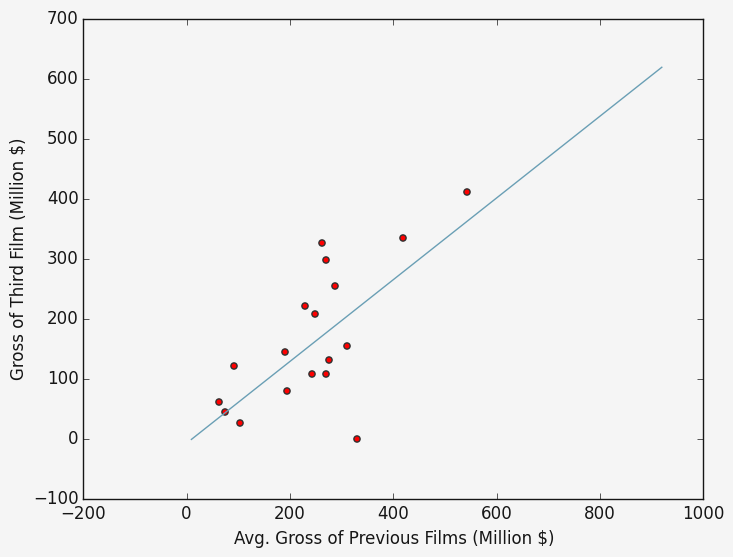

In [12]:
# import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

cleaned_un = collapsed_df[pd.notnull(collapsed_df['prev_meta'])]
cleaned_df= cleaned_un.sort(columns='prev_gross')
var_lab = list(cleaned_df.columns.values)

train, test = train_test_split(cleaned_df, test_size = 0.25)

train_df = pd.DataFrame(train,columns=var_lab).sort(columns='prev_gross') 
test_df = pd.DataFrame(test,columns=var_lab).sort(columns='prev_gross') 


X_train = train_df[['prev_gross']]
Y_train = train_df[['act_gross']]

X_test = test_df[['prev_gross']]
Y_test = test_df[['act_gross']]

sk_linmodel = LinearRegression()
sk_linmodel.fit(X_train,Y_train)

print(sk_linmodel.coef_)
print(sk_linmodel.intercept_)
print(sk_linmodel.score(X_train, Y_train))

pylab.scatter(X_test['prev_gross']/10**6, Y_test/10**6 , c='red')
plt.xlabel('Avg. Gross of Previous Films (Million $)')
plt.ylabel('Gross of Third Film (Million $)')
pylab.plot(X_train['prev_gross']/10**6, sk_linmodel.predict(X_train)/10**6)
plt.show()

## ridge

[[ 0.6879166]]
[-6663202.0948673785]


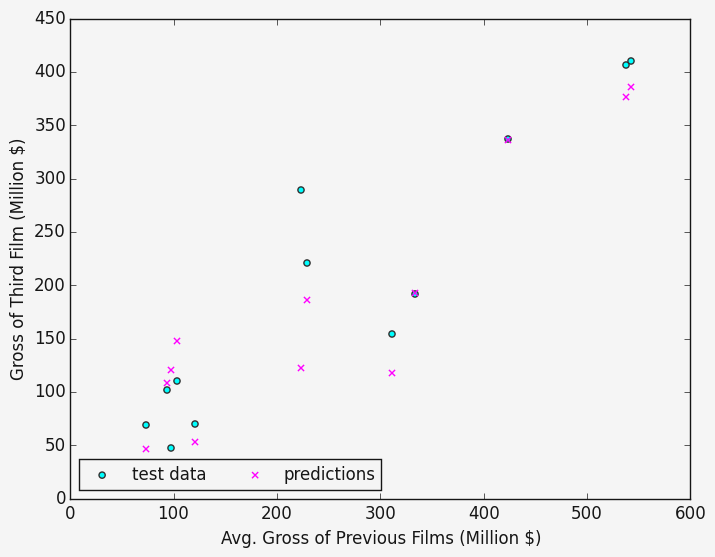

In [26]:
from sklearn.linear_model import ElasticNet

cleaned_un = collapsed_df.dropna()
cleaned_df= cleaned_un.sort(columns='prev_gross')

var_lab = list(cleaned_df.columns.values)

train, test = train_test_split(cleaned_df, test_size = 0.25)

train_df = pd.DataFrame(train,columns=var_lab).sort(columns='prev_gross')  
test_df = pd.DataFrame(test,columns=var_lab).sort(columns='prev_gross')  


X_train = train_df[['prev_gross','act_meta','days_elapsed','same_genre','same_dir']]
Y_train = train_df[['act_gross']]

X_test = test_df[['prev_gross','act_meta','days_elapsed','same_genre','same_dir']]
Y_test = test_df[['act_gross']]

sk_model = ElasticNet(1.0, l1_ratio = 0.5)
sk_model.fit(X_train,Y_train)

xt_sort = collapsed_df.sort(columns='prev_gross')

print(sk_linmodel.coef_)
print(sk_linmodel.intercept_)
# print(sk_linmodel.score(X_train, Y_train))

test_plt=plt.scatter(X_test['prev_gross']/10**6, Y_test/10**6 , c='cyan')
plt.xlabel('Avg. Gross of Previous Films (Million $)')
plt.ylabel('Gross of Third Film (Million $)')
predict_plot=plt.scatter(X_test['prev_gross']/10**6, sk_model.predict(X_test)/10**6, c='magenta', marker='x')
plt.legend((test_plt, predict_plot),
           ('test data', 'predictions'),
           scatterpoints=1,
           loc='lower left',
           ncol=2,
           fontsize=12)
# plt.show()

In [28]:
x_lotr = collapsed_df.loc[collapsed_df['franchise']=='lordoftherings'][['prev_gross','act_meta','days_elapsed','same_genre','same_dir']]
x_btf = collapsed_df.loc[collapsed_df['franchise']=='backtothefuture'][['prev_gross','act_meta','days_elapsed','same_genre','same_dir']]

xbp =sk_model.predict(x_btf)
xlp = sk_model.predict(x_lotr)
print(xbp,xlp)

[  2.24833053e+08] [  4.62003948e+08]


Looking at continuing genre, director

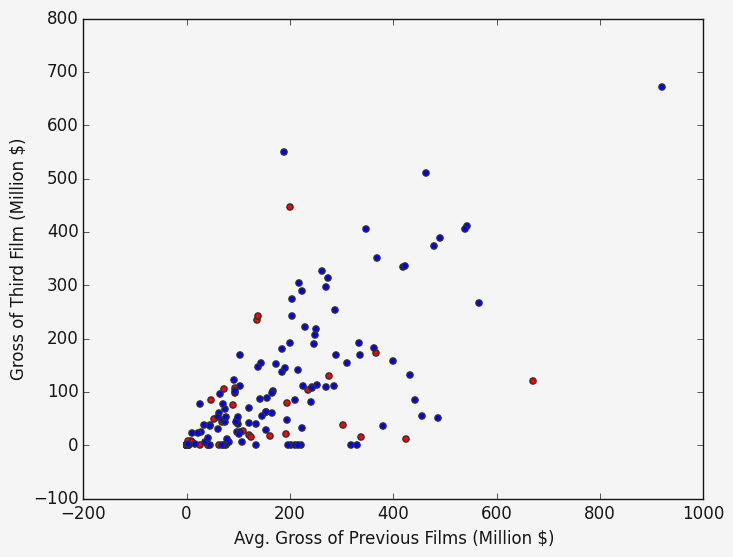

In [30]:
cont_flag = collapsed_df['same_genre']
xcon = cont_flag*collapsed_df['prev_gross']/10**6
ycon = cont_flag*collapsed_df['act_gross']/10**6
xnocon = (-1)*(cont_flag-1)*collapsed_df['prev_gross']/10**6
ynocon = (-1)*(cont_flag-1)*collapsed_df['act_gross']/10**6


plt.scatter(xcon,ycon, c='red')
plt.xlabel('Avg. Gross of Previous Films (Million $)')
plt.ylabel('Gross of Third Film (Million $)')
plt.scatter(xnocon,ynocon, c='blue')
# plt.show()

In [10]:
cont_flag = collapsed_df['same_rating']
xcon = cont_flag*collapsed_df['prev_gross']/10**6
ycon = cont_flag*collapsed_df['act_gross']/10**6
xnocon = (-1)*(cont_flag-1)*collapsed_df['prev_gross']/10**6
ynocon = (-1)*(cont_flag-1)*collapsed_df['act_gross']/10**6


plt.scatter(xcon,ycon, c='red')
plt.xlabel('Avg. Gross of Previous Films (Million $)')
plt.ylabel('Gross of Third Film (Million $)')
plt.scatter(xnocon,ynocon, c='blue')
plt.show()

In [36]:
btf = []
lotr =[]

def makeplot_grosses(movie_list):
    '''Generates and returns line plot of the gross returns over the
      course of a series
    '''
    indices = [i for i in range(1,len(movie_list)+1)]
    grosses = [int(movie[3])/1000000 for movie in movie_list]
    grossplot=plt.plot(indices, grosses);
    return grossplot

for franchise, movies_df in franchise_groups:
    movies_df.drop_duplicates('title', inplace=True)
    if franchise == 'lordoftherings':
        movies_df = movies_df[movies_df.rating != 'PG'] 
        lotr = movies_df.values
    if franchise == 'backtothefuture':
        btf = movies_df.values

s1_label = 'The Lord of the Rings'
s2_label = 'Back to the Future'

In [33]:
xbp =sk_model.predict(x_btf)
xlp = sk_model.predict(x_lotr)
print(x_btf['prev_gross'])
print(xbp[0], xlp[0])

11    366865900
Name: prev_gross, dtype: float64
224833052.83 462003948.386


In [1]:
def makeplot_comp(movie_list):
    '''Generates and returns line plot of the gross returns over the
      course of a series
    '''
    indices = [i for i in range(1,len(movie_list)+1)]
    grosses = [int(movie[3])/1000000 for movie in movie_list]
    grossplot=plt.plot(indices, grosses);
    return grossplot

fig, ax = plt.subplots()
fig.set_size_inches(16,12)
lotr_plot = makeplot_comp(lotr[:3])
btf_plot = makeplot_comp(btf[:3])

plt.title('Box Office Totals for two Popular Trilogies', fontsize=30);
# plt.xlabel("Films", fontsize=15, labelpad=5);
plt.axis([0.8,3.2,0,600])
plt.xticks(rotation=40)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.ylabel("Inflation adjusted Millions of $", fontsize=30, labelpad=15);
plt.setp(ax, xticks=[1, 2, 3], xticklabels=['1st Film', '2nd Film', '3rd Film']);
plt.setp(btf_plot, color='r', alpha=0.7, linewidth=5.0)
plt.setp(lotr_plot, color='k',alpha=0.7, linewidth=5.0)
plt.legend([s1_label, s2_label],loc='lower left')
plt.scatter(3,xbp[0]/1000000, color='r', alpha=0.7, linewidth=8.0)
plt.scatter(3,xlp[0]/1000000, color='k', alpha=0.7, linewidth=8.0)
# fig.show()
# fig.savefig('final_comp.png',dpi=200)

NameError: name 'plt' is not defined